In [18]:
# Import Packages:
import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn import hmm
from matplotlib import pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import PolynomialFeatures

In [19]:
# SPY also captures volatility well. BBUS too, but there is not enough data. Mainly, they are both US ETFs and are not suitable for the argument I want to make.
# https://www.ishares.com/us/products/239623/ishares-msci-eafe-etf
# is composed of large- and mid-cap developed market equities, excluding the US and Canada.

etf = yf.download('EFA', start='2000-01-01', end='2020-09-24')
print(etf)
etf = etf[['Adj Close', 'Volume']] #Using adjusted close (transformed into daily returns) and volume. What other feature of the set can describe volatility?
print(etf)

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2001-08-27  42.916668  42.916668  42.759998  42.833332  26.185722     44700
2001-08-28  42.533333  42.583332  42.263332  42.343334  25.886177    319800
2001-08-29  42.450001  42.466667  42.099998  42.150002  25.767979    128400
2001-08-30  41.666668  41.666668  41.433334  41.549999  25.401180     36900
2001-08-31  41.533333  41.716667  41.466667  41.650002  25.462313   1656900
...               ...        ...        ...        ...        ...       ...
2020-09-17  65.180000  65.680000  65.120003  65.660004  65.660004  18149700
2020-09-18  65.470001  65.500000  64.910004  65.129997  65.129997  27897500
2020-09-21  63.509998  63.560001  62.799999  63.480000  63.480000  39928700
2020-09-22  63.480000  63.549999  62.889999  63.459999  63.459999  15810800
2020-09-23  63.8400

In [20]:
# Initiate HMM instance
hmm_1 = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)

In [21]:
# Transform adjusted close prices to daily returns;
# Remove first adjusted close entry becomes null after the transformation;
# A is our arbitrary Borel set (measurable):
A = np.column_stack([etf['Adj Close'].pct_change()[1:], etf['Volume'][1:]])
print(A[:10])

[[-1.14392601e-02  3.19800000e+05]
 [-4.56608152e-03  1.28400000e+05]
 [-1.42346594e-02  3.69000000e+04]
 [ 2.40667679e-03  1.65690000e+06]
 [-2.28094731e-02  5.70000000e+05]
 [-6.14223530e-03  3.15000000e+04]
 [-2.26620024e-02  2.84700000e+05]
 [-5.90159536e-03  9.99000000e+04]
 [-1.14506798e-02  1.43820000e+06]
 [-4.37581256e-02  1.70400000e+05]]


In [22]:
# Fit model to set A:
hmm_1.fit(A)

GaussianHMM(covariance_type='full', n_components=2, n_iter=1000)

In [23]:
# Predict states through the HMM instantiation above:
hmm_states = hmm_1.predict(A)
print(hmm_states)

[1 1 1 ... 0 1 1]


In [24]:
# Filter states:
hmm_state_0 = hmm_states == 0
hmm_state_1 = hmm_states == 1

In [25]:
# Extract column for convenience:
close_price = etf['Adj Close'][1:]
print(close_price[:10])

Date
2001-08-28    25.886177
2001-08-29    25.767979
2001-08-30    25.401180
2001-08-31    25.462313
2001-09-04    24.881531
2001-09-05    24.728703
2001-09-06    24.168301
2001-09-07    24.025669
2001-09-10    23.750559
2001-09-17    22.711279
Name: Adj Close, dtype: float64


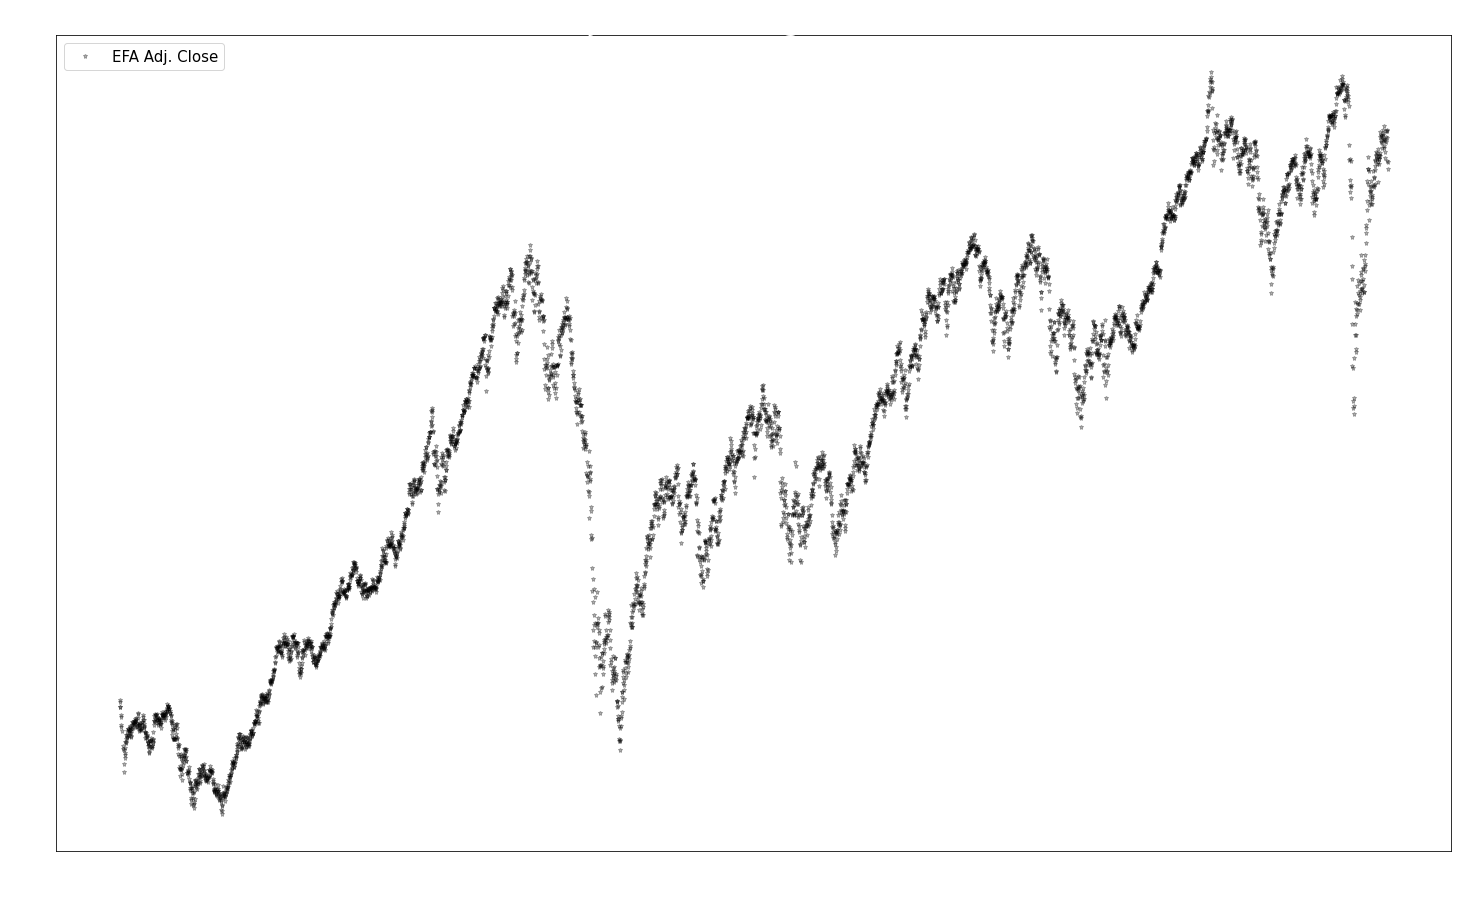

In [26]:
# Plot price data:
default = 'white'
fig = plt.figure(figsize=(25,15))
# Data:
close_price_line = fig.add_subplot(111)
plt.plot_date(close_price.index,close_price, marker='*', ms=5, color='black', alpha=0.3, label='EFA Adj. Close')
# Aesthetic adjustments:
close_price_line.set_title('Adjusted Closing Price, EFA', fontsize=30, color=default)
close_price_line.set_xlabel("Date", fontsize=20, color=default)
close_price_line.set_ylabel("Closing Price", fontsize=20, color=default)
close_price_line.tick_params(axis='both', labelsize=15, colors=default)
close_price_line.legend(loc='upper left', fontsize=15)
# Generate and save graph:
plt.savefig('adj_close_graph.png')
plt.show()

161.6536619390067
169.11938679602292


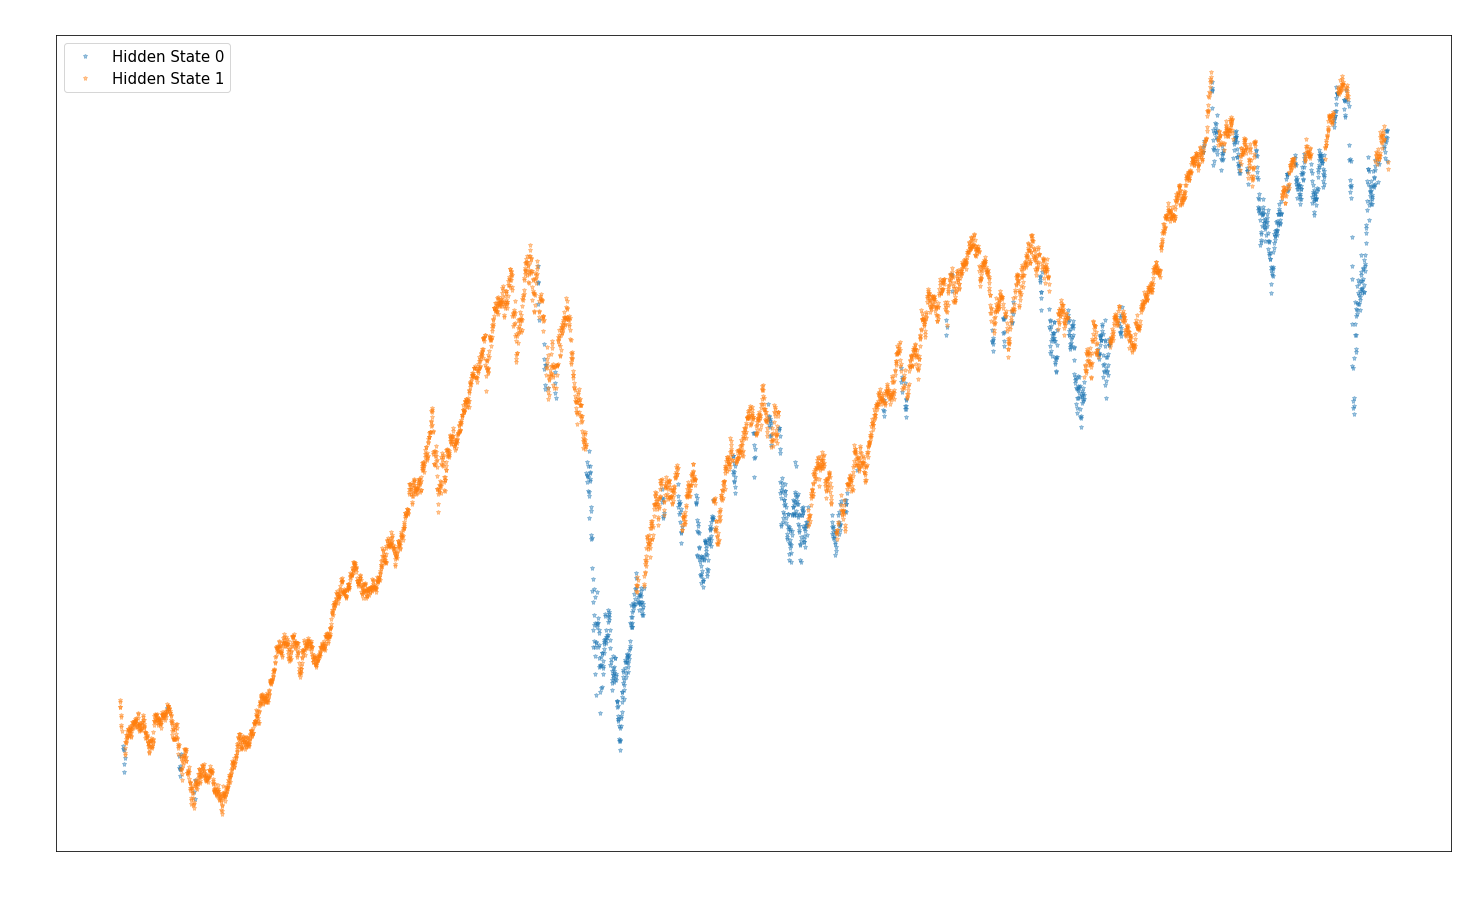

In [27]:
var_hidden_state_0 = np.cov(close_price[hmm_state_0])
print(var_hidden_state_0)
var_hidden_state_1 = np.cov(close_price[hmm_state_1])
print(var_hidden_state_1)

# Plot states:
default = 'white'
fig = plt.figure(figsize=(25,15))
# Data:
markov_states = fig.add_subplot(111)
plt.plot_date(close_price.index[hmm_state_0],close_price[hmm_state_0], marker='*', ms=5, alpha=0.4, label='Hidden State 0')
plt.plot_date(close_price.index[hmm_state_1],close_price[hmm_state_1], marker='*', ms=5, alpha=0.4, label='Hidden State 1')
# Aesthetic adjustments:
markov_states.set_title('Hidden Markov States', fontsize=30, color=default)
markov_states.set_xlabel("Date", fontsize=20, color=default)
markov_states.set_ylabel("Closing Price", fontsize=20, color=default)
markov_states.tick_params(axis='both', labelsize=15, colors=default)
markov_states.legend(loc='upper left', fontsize=15)
# Generate and save graph:
plt.savefig('hmm_graph.png')
plt.show()

In [28]:
data = etf['Adj Close'].tolist()

In [29]:
# Creating monthly partitions/windows that the algorithm uses to predict the current regime.
out = []
for i in range(len(data)):
    train_window = np.array(data[i - 30:i])
    try:
        out.append(train_window / train_window[0])
    except:
        out.append(np.ones(30))

In [30]:
A = np.array(out)
print(A)

[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [1.         1.00330032 1.00691496 ... 1.03048874 1.03190323 1.02357373]
 [1.         1.00360275 1.02584583 ... 1.02850883 1.02020672 0.99436089]
 [1.         1.02216323 1.01763692 ... 1.01654437 0.99079132 0.99047915]]


In [31]:
# Using the Radial Basis Function kernel with default nu value
svm_1 = OneClassSVM(kernel='rbf', nu=0.5, gamma=0.1)

In [32]:
svm_1.fit(PolynomialFeatures(degree=3).fit_transform(A))
print(svm_1)
hmm_states = svm_1.predict(PolynomialFeatures(degree=3).fit_transform(A))
hmm_states_rw = pd.Series(hmm_states).rolling(window=10).mean().fillna(1)
print(hmm_states_rw)

OneClassSVM(gamma=0.1)
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
4794    0.8
4795    0.8
4796    0.8
4797    0.8
4798    0.8
Length: 4799, dtype: float64


In [33]:
# Filter HSVM states:
hmm_states_rw[hmm_states_rw >= 0] = 1
hmm_states_rw[hmm_states_rw < 0] = 0
hmm_states = hmm_states_rw
hmm_states.index = etf.index
hmm_state_0_cluster = hmm_states == 0
hmm_state_1_cluster = hmm_states == 1

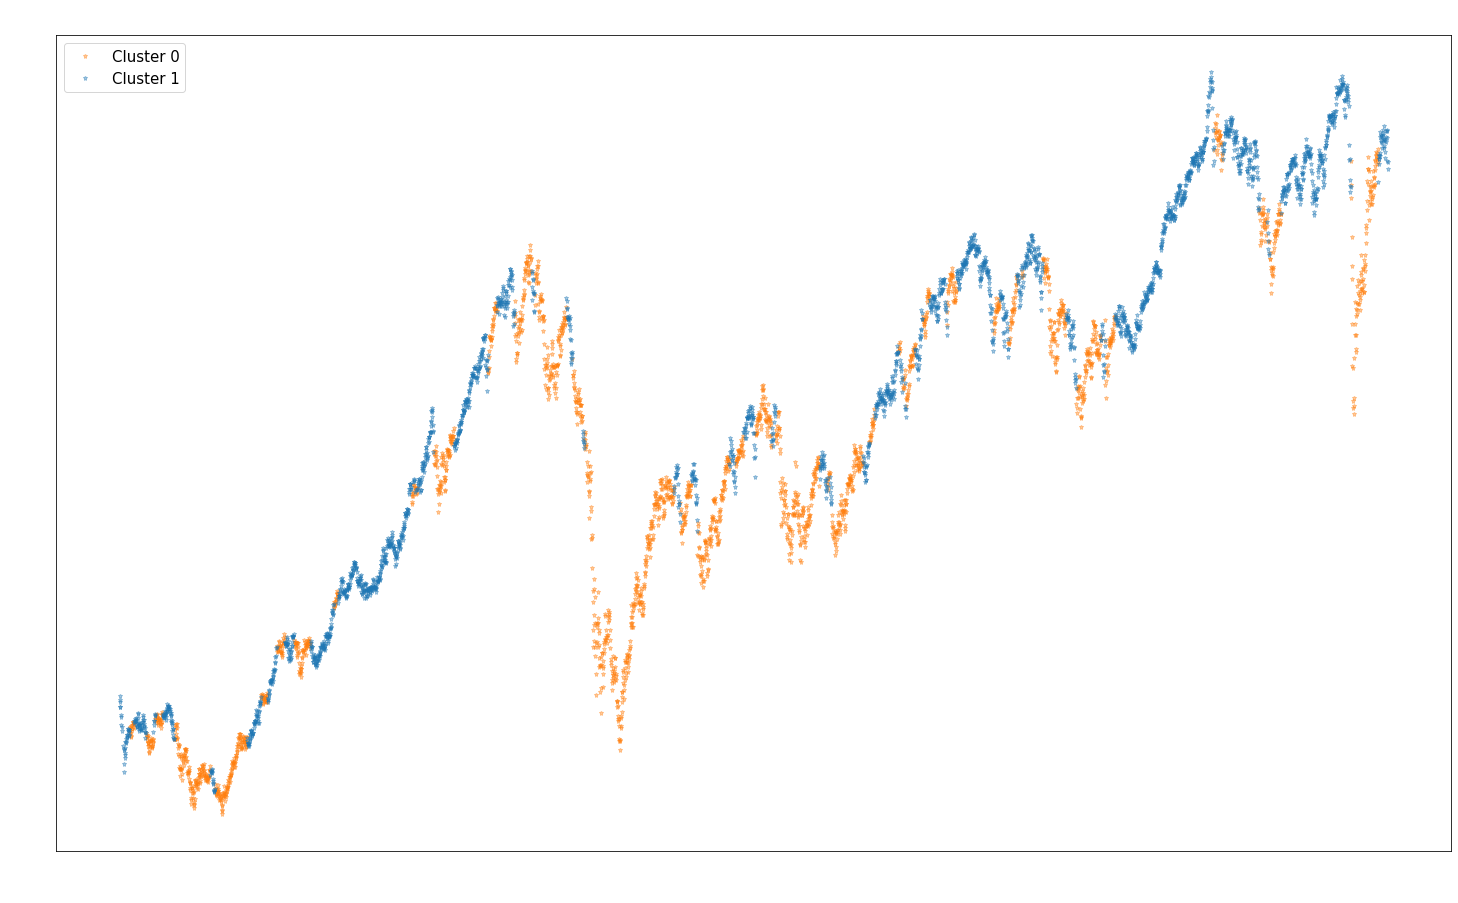

In [34]:
# Plot Hidden SVM states:
default = 'white'
fig = plt.figure(figsize=(25,15))
# Data:
hidden_svm_states = fig.add_subplot(111)
plt.plot_date(etf.index[hmm_state_0_cluster],etf['Adj Close'][hmm_state_0_cluster], marker='*', ms=5, alpha=0.4, color='C1', label='Cluster 0')
plt.plot_date(etf.index[hmm_state_1_cluster],etf['Adj Close'][hmm_state_1_cluster], marker='*', ms=5, alpha=0.4, color='C0',label='Cluster 1')
# Aesthetic adjustments:
hidden_svm_states.set_title('SVM Clusters', fontsize=30, color=default)
hidden_svm_states.set_xlabel("Date", fontsize=20, color=default)
hidden_svm_states.set_ylabel("Closing Price", fontsize=20, color=default)
hidden_svm_states.tick_params(axis='both', labelsize=15, colors=default)
hidden_svm_states.legend(loc='upper left', fontsize=15)
# Generate and save graph:
plt.savefig('hmm_svm_graph.png')
plt.show()